In [1]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn import metrics 
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import GridSearchCV

%precision %.7g
%matplotlib inline

# KNN

## 1. Explore

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/diabetes2.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 2. Build and Evaluate Model

In [11]:
predictors = ["BMI", "BloodPressure"]

X = data[predictors]
y = data["Outcome"]

n_neighbors = 20
knn = KNeighborsClassifier(n_neighbors = n_neighbors)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

z = StandardScaler()
Xz_train = z.fit_transform(X_train)
Xz_test = z.transform(X_test)

knn.fit(Xz_train,y_train)


KNeighborsClassifier(n_neighbors=20)

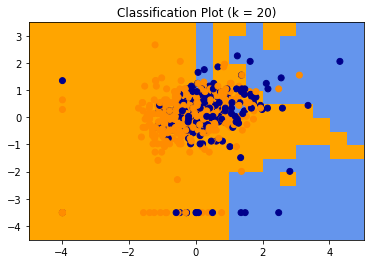

In [12]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plotKNN(X,y, title, n_neighbors, model):
    #adapted from: https://pythonspot.com/k-nearest-neighbors/
    h = .5  # step size in the mesh
    # Create color maps
    cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
    cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])
    # calculate min, max and limits
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h))

    # predict class using data and kNN classifier
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Classification Plot (k = %i)" % (n_neighbors))
    plt.show()
    
    
plotKNN(X = Xz_train,y = y_train, title = "KNN", n_neighbors = n_neighbors, model = knn)

In [13]:
knn.score(Xz_test,y_test)

0.6883116883116883

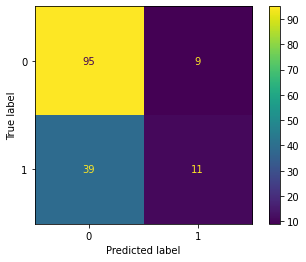

In [15]:
plot_confusion_matrix(knn, Xz_test, y_test)

# Parameter Tuning

## Option 1: By Hand

In [19]:
predictors = ["BMI", "BloodPressure"]

X = data[predictors]
y = data["Outcome"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# split training set into train and validation
X_train2, X_val, y_train2, y_val = train_test_split(X_train,y_train, test_size = 0.2)

# choose possible parameter values to test
poss_k = [1,2,3,4,5,6,7,8,9,10]
acc = {}

# test parameters
for k in poss_k:
    knn3 = KNeighborsClassifier(n_neighbors = k)
    knn3.fit(X_train2, y_train2)
    acc[k] = knn3.score(X_val, y_val)
print(acc)

# choose best param
chosen_k = max(acc, key=acc.get)
print(chosen_k)

# fit model with best param
knn_final = KNeighborsClassifier(n_neighbors = chosen_k)
knn_final.fit(X_train, y_train)

knn_final.score(X_test,y_test)

{1: 0.5609756097560976, 2: 0.5853658536585366, 3: 0.5853658536585366, 4: 0.6341463414634146, 5: 0.5609756097560976, 6: 0.6178861788617886, 7: 0.6422764227642277, 8: 0.6178861788617886, 9: 0.6097560975609756, 10: 0.5934959349593496}
7


0.6493506493506493

## Option 2 (recommended): Grid Search

In [20]:
# what K do I use??

predictors = ["BMI", "BloodPressure"]

X = data[predictors]
y = data["Outcome"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# create model
knn2 = KNeighborsClassifier()

# choose potential values of k
ks = {"n_neighbors": range(1,30)}

# use grid search to find best parameters
grid = GridSearchCV(knn2, ks, scoring = "accuracy", cv = 5)

knnmond = grid.fit(X_train, y_train)

In [23]:
knnmond.best_estimator_.get_params()["n_neighbors"]

25

In [24]:
knnmond.best_score_
# more things you can pull: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

0.6644675463148074

In [25]:
knnmond.score(X_test, y_test)

0.6558441558441559

## Data Leakage (Reprise)

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# what K do I use??
predictors = ["BMI", "BloodPressure"]

X = data[predictors]
y = data["Outcome"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# create model
knn2 = KNeighborsClassifier()

# create z score object
z = make_column_transformer((StandardScaler(),
                            ["BMI", "BloodPressure"]))
# make pipeline
pipe = make_pipeline(z, knn2)
print(pipe.get_params().keys())

# choose potential values of k
ks = {"kneighborsclassifier__n_neighbors": range(1,30)}

# use grid search to find best parameters
grid = GridSearchCV(pipe, ks, scoring = "accuracy", cv = 5, refit = True)

knnmod = grid.fit(X_train, y_train)

knnmod.best_estimator_.get_params()["kneighborsclassifier__n_neighbors"]

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'kneighborsclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__standardscaler', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])


8

## What else can we Grid Search???

Grid search is a super simple way to choose hyperparameters. There other more efficient ways to tune hyperparameters, but this does a good job in simple cases like the ones we will see in class.

It doesn't just work for K in KNN though! Think about `max_depth` when building a DecisionTree, this can be chosen using `GridSearchCV()` as well.

In [31]:
from sklearn.tree import DecisionTreeClassifier # Decision Tree

# load data from DT lecture
gpa = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/CCfraud.csv")

# set X and y
X = gpa[["home","amount","cashBack"]]
y = gpa["fraud"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# make z score object
z = make_column_transformer((StandardScaler(),
                            ["amount"]))
# make model
tree = DecisionTreeClassifier()

# make pipe
pipe = make_pipeline(z,tree)
print(pipe.get_params().keys())


# choose potential values of k
depths = {"decisiontreeclassifier__max_depth": range(1,9)}

# use grid search to find best parameters
grid = GridSearchCV(pipe, depths, scoring = "accuracy", cv = 5, refit = True)

DTmod = grid.fit(X_train, y_train)


dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'decisiontreeclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__standardscaler', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__with_std', 'decisiontreeclassifier__ccp_alpha', 'decisiontreeclassifier__class_weight', 'decisiontreeclassifier__criterion', 'decisiontreeclassifier__max_depth', 'decisiontreeclassifier__max_features', 'decisiontreeclassifier__max_leaf_nodes', 'decisiontreeclassifier__min_impurity_decrease', 'decisiontreeclassifier__min_impurity_split', 'decisiontreeclassifier__min_samples_leaf', 'decisiontreeclassifier__min_samples_split', 'decisiontreeclassifier__min_weight_fraction_leaf', 'decisiontreeclassifier__presort', 'decisiontreeclassifier__r

In [32]:
DTmod.best_estimator_.get_params()["decisiontreeclassifier__max_depth"]

1

In [33]:
DTmod.predict(X_test)

array([1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1])

In [34]:
DTmod

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['amount'])])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__max_depth': range(1, 9)},
             scoring='accuracy')